In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import warnings
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk
import langid

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [10]:
data = pd.read_csv("lyrics.csv")
print(data.shape)
data.head(10)

(362237, 6)


,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."
5,5,all-i-could-do-was-cry,2009,beyonce-knowles,Pop,I heard\nChurch bells ringing\nI heard\nA choi...
6,6,once-in-a-lifetime,2009,beyonce-knowles,Pop,This is just another day that I would spend\nW...
7,7,waiting,2009,beyonce-knowles,Pop,"Waiting, waiting, waiting, waiting\nWaiting, w..."
8,8,slow-love,2009,beyonce-knowles,Pop,[Verse 1:]\nI read all of the magazines\nwhile...
9,9,why-don-t-you-love-me,2009,beyonce-knowles,Pop,"N-n-now, honey\nYou better sit down and look a..."


In [11]:
def removeNumbers(lyric):
    return ''.join(x for x in lyric if not x.isnumeric())

In [21]:
def clean_data(data):
    data = data[(data['genre'] != 'Not Available') & (data['genre'] != 'Other' )]
    data = data.dropna(subset=['genre', 'lyrics'])
    data["lyrics"] = data["lyrics"].apply(removeNumbers)
    data["language"] = data["lyrics"].apply(lambda x: ' '.join(x.split()[10:15]))
    data["language"] = data["language"].apply(langid.classify)
    data = data[['en' in lang for lang in data['language']]]
    return data

In [13]:
def balance_data(data,genre):
    data_selected = data[(data['genre'] == genre)]
    data_selected["genre"] = 1
    data_adverse = data[(data['genre'] != genre)]
    data_adverse["genre"] = 0
    selected_train, selected_test = train_test_split(data_selected, test_size=0.2)
    data_adverse = data_adverse.sample(n=len(data_selected), random_state=1)
    adverse_train, adverse_test = train_test_split(data_adverse, test_size=0.2)
    selected_train = selected_train.append(adverse_train, ignore_index = True)
    selected_test = selected_test.append(adverse_test, ignore_index = True)
    selected_train = shuffle(selected_train)
    selected_test = shuffle(selected_test)
    return selected_train["lyrics"], selected_test["lyrics"],  selected_train["genre"], selected_test["genre"]

In [14]:
def regression_classifier(data,genre):
    docs_train, docs_test, y_train, y_test = balance_data(data,genre)
    docs_train = docs_train.append(docs_test)
    y_train = y_train.append(y_test)
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(docs_train)
    logisReg = LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr').fit(X_train, y_train)
    return (genre, logisReg, vectorizer)

In [15]:
def genre_classifiers(data):
    genre_list = np.unique(data['genre'])
    return [regression_classifier(data,genre) for genre in genre_list]

In [16]:
def make_prediction(song, classifiers):
    max_prob = 0
    best_genre = None
    for genre,lr,vectorizer in classifiers:
        X_song = vectorizer.transform(song)
        aux_prob = lr.predict_proba(X_song)[:,1]
        if max_prob<aux_prob:
            max_prob = aux_prob
            best_genre = genre
    return best_genre

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
def print_measures(songs, classifiers, data_validation):
    predictions = []
    
    for song in songs:
        song = [song]
        predictions.append(make_prediction(song,classifiers))
    sum_right = 0
    
    for i in range(0,len(data_validation['genre'])):
        if predictions[i] == data_validation['genre'].iloc[i]:
            sum_right = sum_right + 1
    print("Accuracy:\n", sum_right/len((data_validation['genre'])))
    print("Confusion Matrix:\n", confusion_matrix(predictions, data_validation['genre']))
    print("Classification Report:\n", classification_report(predictions, data_validation['genre']))
    
    return predictions

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics

def sklearn_ovr_model(data_train, data_validation):
    y_train = data_train["genre"]
    y_test = data_validation["genre"]
    docs_train = data_train["lyrics"]
    docs_test = data_validation["lyrics"]

    genre_list = np.unique(data["genre"])
    enc = preprocessing.LabelEncoder()
    enc.fit(genre_list)
    y_train = enc.transform(y_train)
    y_test = enc.transform(y_test)

    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(docs_train)
    logisReg = LogisticRegression(random_state=0, solver='liblinear', multi_class='ovr').fit(X_train, y_train)
    X_test = vectorizer.transform(docs_test)
    y_hat = logisReg.predict(X_test)

    print("Logistic Regression accuracy is: ", metrics.accuracy_score(y_test, y_hat))
    print("Confusion Matrix:\n", confusion_matrix(predictions, data_validation['genre']))
    print("Classification Report:\n", classification_report(y_test, y_hat))
    
    return y_test, y_hat

In [19]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

In [22]:
# Use for evaluation purposes

#data = clean_data(data)
#genre_list = np.unique(data['genre'])
#enc = preprocessing.LabelEncoder()
#enc.fit(genre_list)
#data_train, data_validation = train_test_split(data, test_size=0.2)
#classifiers = [regression_classifier(data_train,genre) for genre in genre_list]

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [25]:
# Plot normalized confusion matrix manually balance
#predictions = print_measures(data_validation['lyrics'], classifiers, data_validation)
#label_test = enc.transform(data_validation['genre'])
#label_prediction = enc.transform(predictions)
#plot_confusion_matrix(label_test, label_prediction, classes=genre_list, normalize=True,
#                      title='Confusion matrix balance')

#plt.show()

Accuracy:
 0.45893526513077537
Confusion Matrix:
 [[1608   42   53   53   51  224   37  617   54 1977]
 [  59  424   24  166   66   50  213  682   37 1632]
 [ 126  125  150   58   44   93  254  254   13 1190]
 [  21  112    5 3845   10   19   90  433   41  469]
 [  91   75   24   59  104   38   97  392   21 1333]
 [ 260   56   33   57   37  600   44  575   70 1093]
 [  39  146   21  100   30   20 3257  327   39 1990]
 [ 223  283   40  370   74  210  144 3132  114 2403]
 [ 119   75   12  122   26   99   50  566  144 1181]
 [ 373  293   74  153  208  145  549 1188  138 8529]]
Classification Report:
               precision    recall  f1-score   support

     Country       0.55      0.34      0.42      4716
  Electronic       0.26      0.13      0.17      3353
        Folk       0.34      0.07      0.11      2307
     Hip-Hop       0.77      0.76      0.77      5045
       Indie       0.16      0.05      0.07      2234
        Jazz       0.40      0.21      0.28      2825
       Metal    

NameError: name 'enc' is not defined

Normalized confusion matrix
[[0.55087359 0.0202124  0.04316547 0.00719424 0.03117506 0.0890716
  0.01336074 0.07639603 0.04076739 0.12778349]
 [0.02575107 0.25996321 0.0766401  0.06866953 0.04598406 0.03433476
  0.08951563 0.17351318 0.04598406 0.17964439]
 [0.12155963 0.05504587 0.3440367  0.01146789 0.05504587 0.07568807
  0.04816514 0.09174312 0.02752294 0.16972477]
 [0.01063616 0.03331327 0.01163957 0.77162352 0.01184026 0.01143889
  0.02006823 0.07425246 0.02448324 0.03070439]
 [0.07846154 0.10153846 0.06769231 0.01538462 0.16       0.05692308
  0.04615385 0.11384615 0.04       0.32      ]
 [0.14953271 0.03337784 0.06208278 0.01268358 0.02536716 0.40053405
  0.01335113 0.14018692 0.06608812 0.09679573]
 [0.00781415 0.04498416 0.05364308 0.01900739 0.02048574 0.0092925
  0.68785639 0.03041183 0.01055966 0.11594509]
 [0.07555719 0.08351702 0.03110458 0.05302474 0.04800392 0.07041391
  0.04004409 0.38354151 0.06931178 0.14548126]
 [0.0804769  0.05514158 0.01937407 0.06110283 0.031296

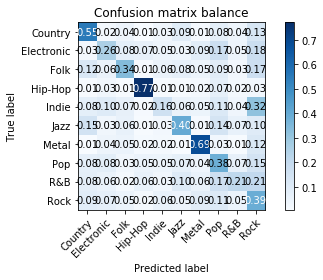

In [26]:
#enc = preprocessing.LabelEncoder()
#enc.fit(genre_list)
#label_test = enc.transform(data_validation['genre'])
#label_prediction = enc.transform(predictions)
#plot_confusion_matrix(label_test, label_prediction, classes=genre_list, normalize=True,
#                      title='Confusion matrix balance')

#plt.show()

Logistic Regression accuracy is:  0.6148759634418566
Confusion Matrix:
 [[1608   42   53   53   51  224   37  617   54 1977]
 [  59  424   24  166   66   50  213  682   37 1632]
 [ 126  125  150   58   44   93  254  254   13 1190]
 [  21  112    5 3845   10   19   90  433   41  469]
 [  91   75   24   59  104   38   97  392   21 1333]
 [ 260   56   33   57   37  600   44  575   70 1093]
 [  39  146   21  100   30   20 3257  327   39 1990]
 [ 223  283   40  370   74  210  144 3132  114 2403]
 [ 119   75   12  122   26   99   50  566  144 1181]
 [ 373  293   74  153  208  145  549 1188  138 8529]]


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.24      0.34      2919
           1       0.79      0.02      0.03      1631
           2       0.94      0.04      0.07       436
           3       0.84      0.73      0.79      4983
           4       0.00      0.00      0.00       650
           5       0.59      0.14      0.22      1498
           6       0.76      0.51      0.61      4735
           7       0.52      0.32      0.40      8166
           8       1.00      0.03      0.05       671
           9       0.59      0.90      0.71     21797

   micro avg       0.61      0.61      0.61     47486
   macro avg       0.66      0.29      0.32     47486
weighted avg       0.63      0.61      0.57     47486

Normalized confusion matrix
[[2.36724906e-01 0.00000000e+00 0.00000000e+00 3.08324769e-03
  0.00000000e+00 9.24974306e-03 5.82391230e-03 6.09797876e-02
  0.00000000e+00 6.84138404e-01]
 [1.22624157e-03 1.59411404e-02 

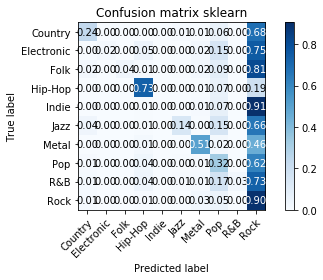

In [27]:
# Plot normalized confusion matrix using sklearn model
#y_test, y_hat = sklearn_ovr_model(data_train, data_validation)
#plot_confusion_matrix(y_test, y_hat, classes=genre_list, normalize=True,
                      title='Confusion matrix sklearn')

#plt.show()